# 2025 Policy Challenge
## Understanding the Impact of Rats on Washington DC

Mike Johnson | Andrea Morante | Andrew Singh

****

In [1]:
# Import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Temperature Libraries
from meteostat import Point, Daily, Monthly
from datetime import datetime

# Machine Learning Libraries
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

#### DC 311 Data
DC 311 is a service by the District of Columbia government to provide constintuents, residents, and visitors to access to city services and information. The services handles non-emergency service requests and provides information on various city services. This includes service requests related to rodents.

Using 311 City Service Request data on https://opendata.dc.gov/, we can understand the impact of rats on Washington DC. 

Links to each year collected for this analysis:
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2024/
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2023/
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2022/
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2021/
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2020/
* https://opendata.dc.gov/datasets/DCGIS::311-city-service-requests-in-2019/

Data sets have been prepped and cleaned in a separate script. A copy of the script can be found here: https://github.com/mjohnsonsea/dc_rats_311

In [2]:
# Columns to keep for analysis
keep_cols = ['ADDDATE',
             'SERVICECALLCOUNT']

# Define data types for 311 data
dtypes = {'ADDDATE': 'str', # Covert to DT after import
          'SERVICECALLCOUNT': 'int'}
          
# Load DC 311 data
df = pd.read_csv('dc_rats_311.csv',
                 usecols = keep_cols,
                 dtype = dtypes)

# Convert ADDDATE column to datetime
df['ADDDATE'] = pd.to_datetime(df['ADDDATE']).dt.tz_localize(None)

df

,SERVICECALLCOUNT,ADDDATE
0,1,2019-01-29 12:58:02
1,1,2019-01-28 23:59:44
2,1,2019-01-31 16:35:01
3,1,2019-01-04 02:04:51
4,1,2019-01-05 06:25:47
...,...,...
76724,1,2025-02-10 19:40:56
76725,1,2025-02-10 20:09:23
76726,1,2025-02-10 20:44:52
76727,1,2025-02-10 20:51:34


In [3]:
# Get df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76729 entries, 0 to 76728
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SERVICECALLCOUNT  76729 non-null  int32         
 1   ADDDATE           76729 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 899.3 KB


In [4]:
# Group data by day
df = df.groupby([pd.Grouper(key='ADDDATE', freq='D')], as_index = False).sum()
df = df.ffill()
df

,ADDDATE,SERVICECALLCOUNT
0,2019-01-01,2
1,2019-01-02,15
2,2019-01-03,20
3,2019-01-04,19
4,2019-01-05,2
...,...,...
2228,2025-02-06,33
2229,2025-02-07,50
2230,2025-02-08,14
2231,2025-02-09,15


### Get temperatures for Washington DC

In [5]:
# Define the location
location = Point(38.907192, -77.036873)  # Latitude and Longitude for Washington, DC

# Define the time period
start_date = datetime(2019, 1, 1)
end_date = datetime(2025, 2, 10)

# Fetch the daily weather data
data = Daily(location, start_date, end_date)
data = data.fetch()

# Convert the data to a DataFrame
df_temp = pd.DataFrame(data).reset_index()

# Filter to relevant columns
df_temp = df_temp[['time', 'tavg']]

df_temp

,time,tavg
0,2019-01-01,13.6
1,2019-01-02,7.9
2,2019-01-03,8.5
3,2019-01-04,5.9
4,2019-01-05,9.1
...,...,...
2228,2025-02-06,3.4
2229,2025-02-07,5.6
2230,2025-02-08,2.2
2231,2025-02-09,4.9


### Merge 311 and Temperature data

In [6]:
# Merge dataframes
df = pd.merge(df, df_temp,
              how = "left",
              left_on = "ADDDATE",
              right_on= "time")

# Drop time column
df = df.drop(columns = ['ADDDATE','time'])

df

,SERVICECALLCOUNT,tavg
0,2,13.6
1,15,7.9
2,20,8.5
3,19,5.9
4,2,9.1
...,...,...
2228,33,3.4
2229,50,5.6
2230,14,2.2
2231,15,4.9


****

## Linear Regression

### Step 1: Create Train/Test Split

In [7]:
# Define X and Y
X = df[['tavg']]
y = df['SERVICECALLCOUNT']

# Create train-test split
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, df.index, test_size=0.2, random_state=206)

### Step 2: Data Exploration

In [8]:
# Create df with train set for exploration
df_train = df.loc[train_indices]

df_train


,SERVICECALLCOUNT,tavg
944,43,23.6
432,7,8.7
1090,4,14.4
35,14,10.2
729,30,2.6
...,...,...
2060,80,20.9
502,22,18.7
191,26,26.7
2110,55,14.8


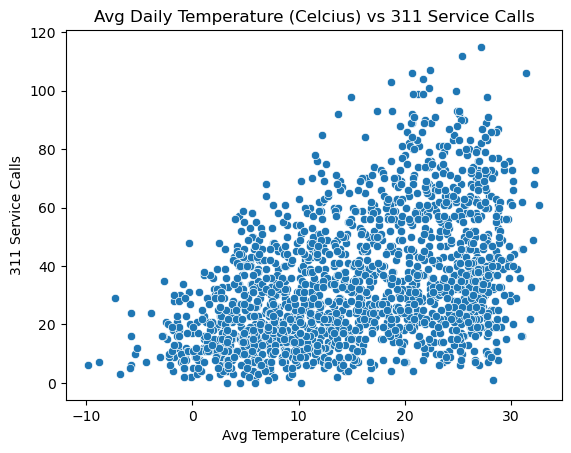

In [9]:
# Visualize relationship between temp and service calls
sns.scatterplot(data = df_train,
                x = 'tavg',
                y = 'SERVICECALLCOUNT')

# Labels
plt.title('Avg Daily Temperature (Celcius) vs 311 Service Calls')
plt.xlabel('Avg Temperature (Celcius)')
plt.ylabel('311 Service Calls')

plt.show()

### Step 3: Data pre-processing

In [10]:
# N/A

### Step 4: Feature Engineering

In [11]:
# N/A

### Step 5: Feature & Model Selection

In [12]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Model Summary

# Intercept
intercept = model.intercept_

# Coefficients (marginal effects)
coefficients = model.coef_

print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')


Intercept: 18.40768185209747
Coefficients: [1.03157192]


In [13]:
# Make predictions on training data
y_train_pred = model.predict(X_train)

# Evaluate model on training data
mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mse_train = round(mean_squared_error(y_train, y_train_pred), 2)
r2_train = round(r2_score(y_train, y_train_pred), 2)

print(f"Mean Absolute Error (MAE): {mae_train}") 
print(f"Mean Squared Error (MSE): {mse_train}") 
print(f"R-squared (R2): {r2_train}")

Mean Absolute Error (MAE): 15.66
Mean Squared Error (MSE): 372.59
R-squared (R2): 0.19


### Step 6: Model Validation

In [14]:
# Define scoring metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring, return_train_score=True)

# Calculate mean and standard deviation of the cross-validation scores
mean_mae = round(cv_results['test_MAE'].mean(),2)
mean_mse = round(cv_results['test_MSE'].mean(),2)
mean_r2 = round(cv_results['test_R2'].mean(),2)

print(f'Mean Cross-Validation MAE: {mean_mae}')
print(f'Mean Cross-Validation MSE: {mean_mse}')
print(f'Mean Cross-Validation R²: {mean_r2}')


Mean Cross-Validation MAE: 15.68
Mean Cross-Validation MSE: 373.52
Mean Cross-Validation R²: 0.18


### Step 7: Predictions and Conclusions

In [15]:
# Make predictions on test data
y_test_pred = model.predict(X_test)

# Evaluate model on test data
mae_test = round(mean_absolute_error(y_test, y_test_pred), 2)
mse_test = round(mean_squared_error(y_test, y_test_pred), 2)
r2_test = round(r2_score(y_test, y_test_pred), 2)

print(f"Mean Absolute Error (MAE): {mae_test}") 
print(f"Mean Squared Error (MSE): {mse_test}") 
print(f"R-squared (R2): {r2_test}")

Mean Absolute Error (MAE): 15.32
Mean Squared Error (MSE): 365.91
R-squared (R2): 0.18
